In [9]:
import scipy as sc
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

%matplotlib inline

<Axes: xlabel='Date'>

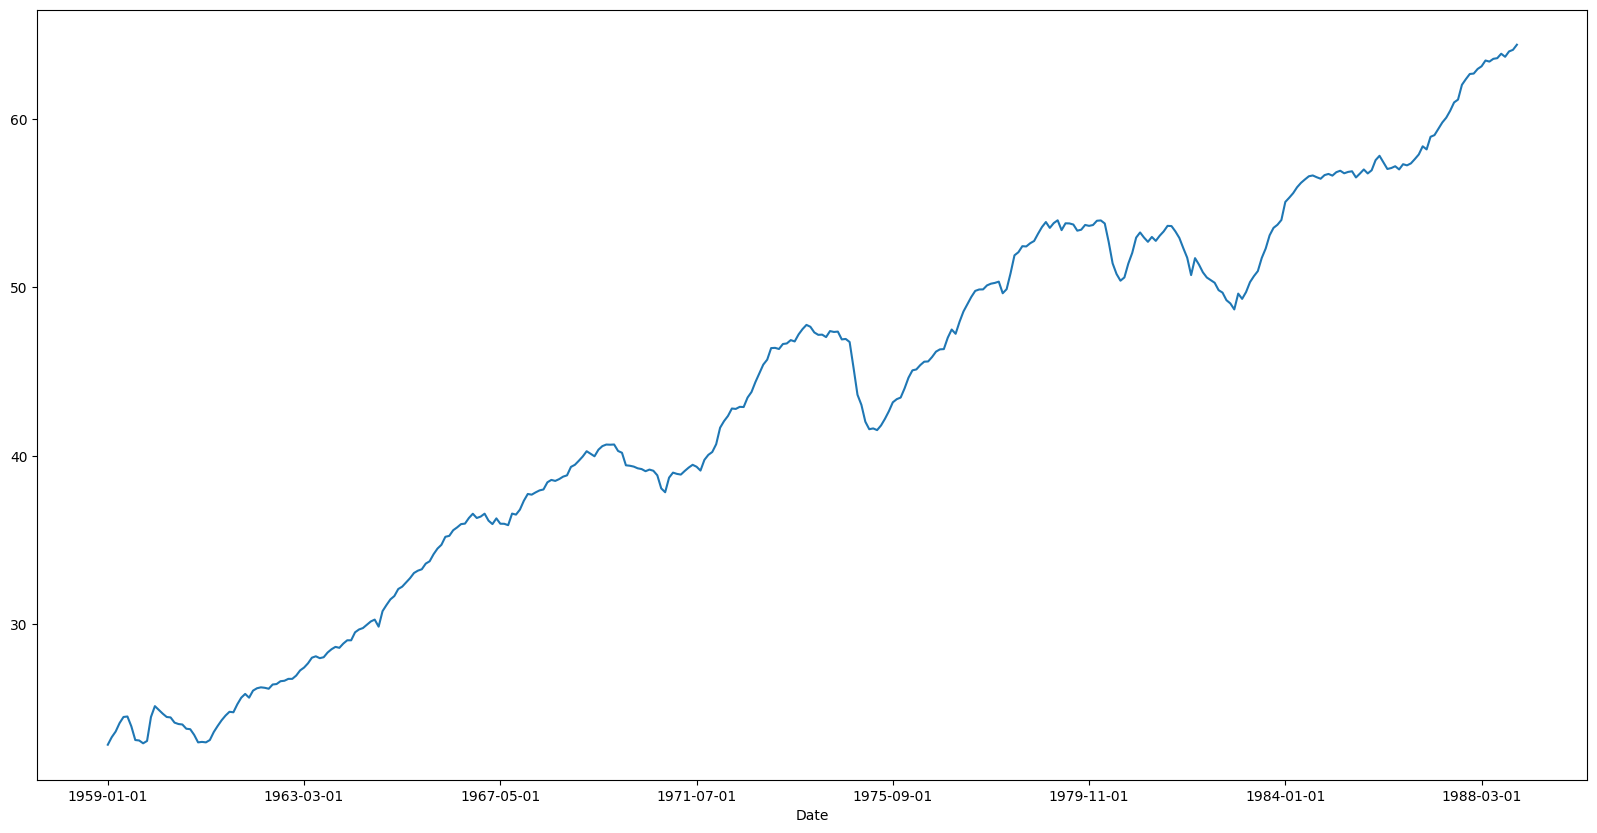

In [10]:
data = pd.read_csv('training.csv')
train_ser = pd.Series(np.asarray(data['Value']), index=data['Date'])
train_ser.plot(figsize=(20, 10))

**1. Скользящая статистика**

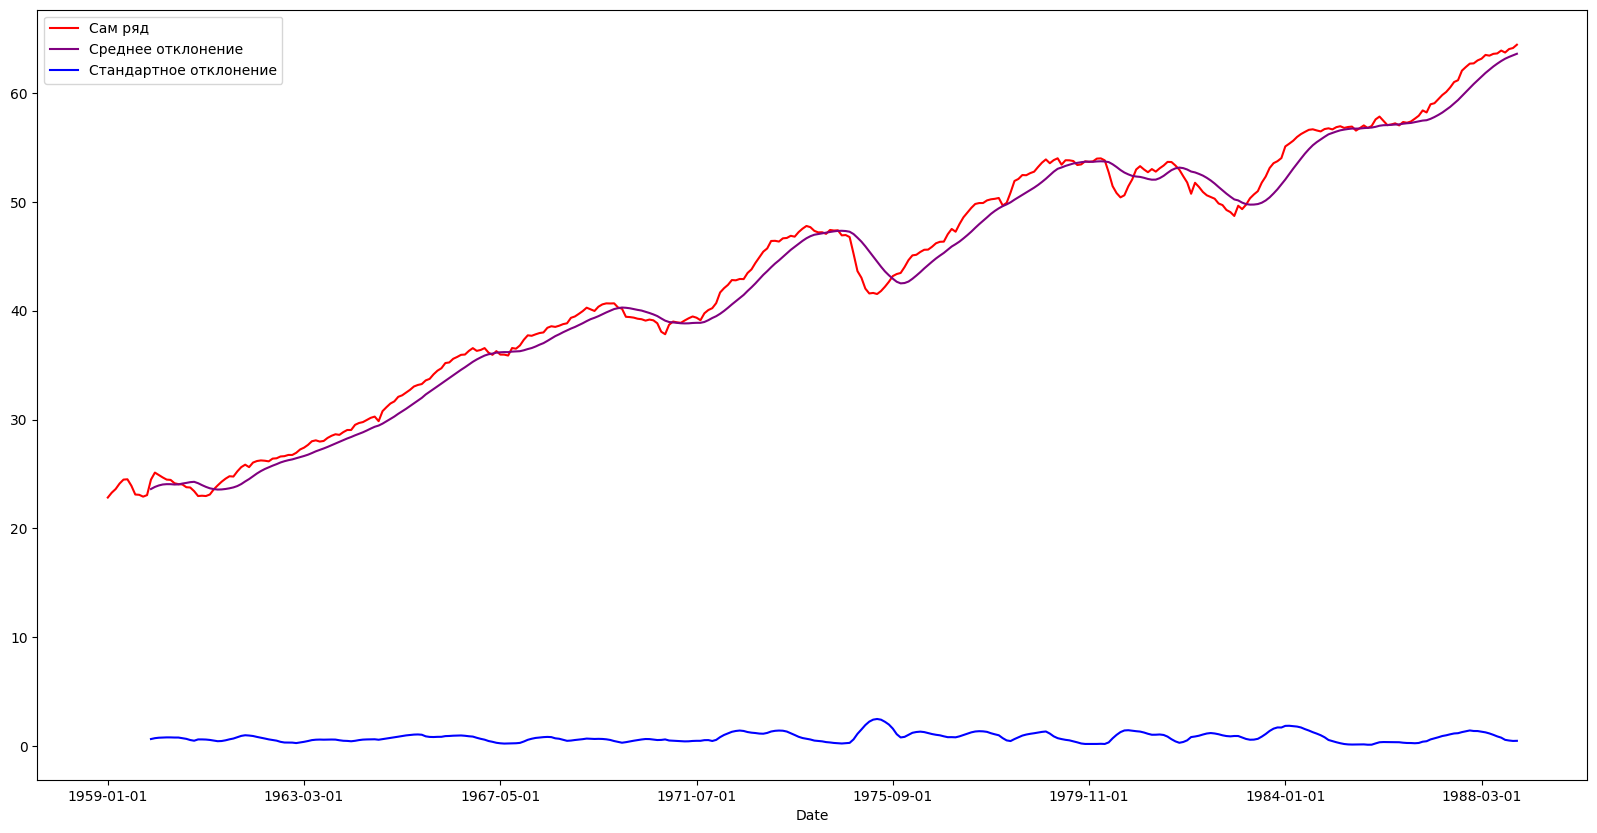

In [11]:
def draw_stats(train_ser):
    train_ser.plot(color='r', legend=True, figsize=(20, 10), label='Сам ряд')
    train_ser.rolling(window=12,center=False).mean().plot(color='purple', legend=True, label='Среднее отклонение')
    train_ser.rolling(window=12, center=False).std().plot(color='b', legend=True, label = 'Стандартное отклонение')

draw_stats(train_ser)

**2. Тест Дики - Фуллера**

In [12]:
def DF_test(train_ser, isPrint=True):
    test = sm.tsa.adfuller(train_ser)

    if isPrint:
        print('adf: ', test[0])
        print('p-value: ', test[1])
        print('Critical values: ', test[4])

    if test[0] > test[4]['5%']:
        if isPrint:
            print('Не стационарно')

        return False
    else:
        if isPrint:
            print('Стационарно')

        return True

    return False

DF_test(train_ser)

adf:  -0.2533911799284611
p-value:  0.9318510422993468
Critical values:  {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459}
Не стационарно


False

**3. Разложение на тренд, сезональность, остаток.**

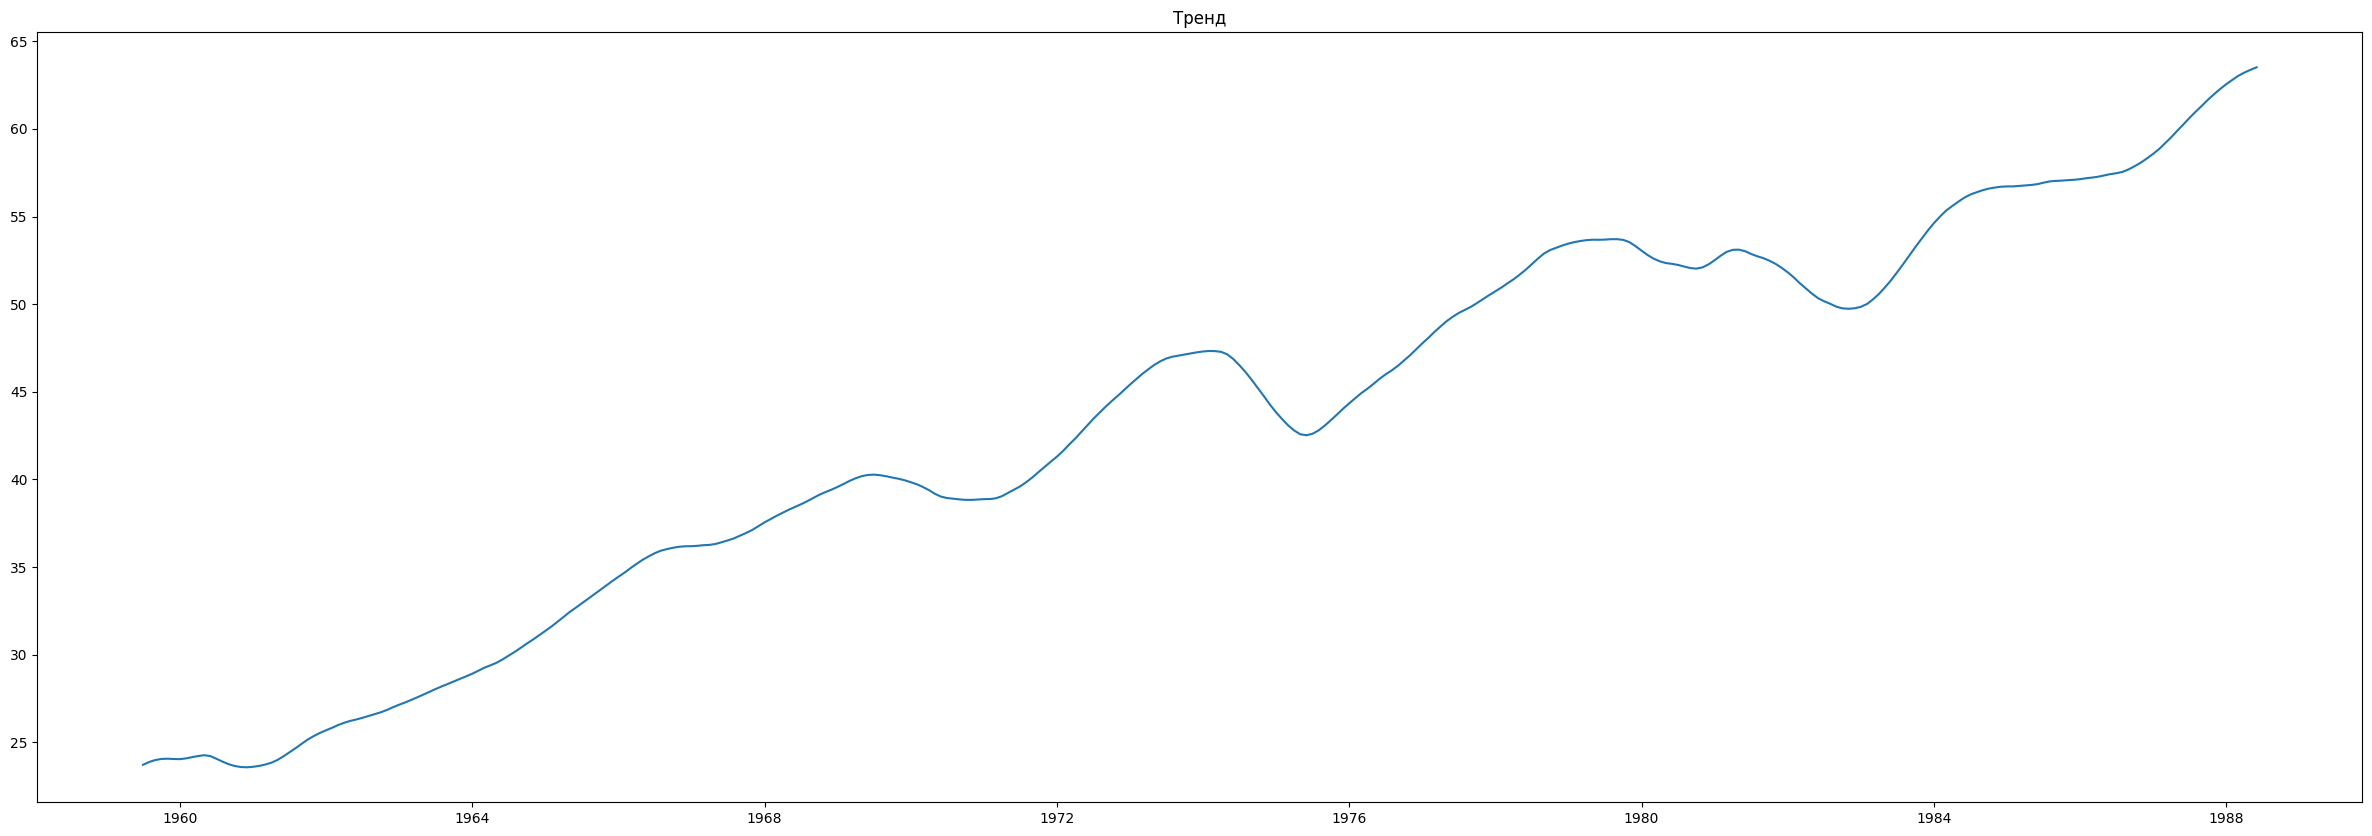

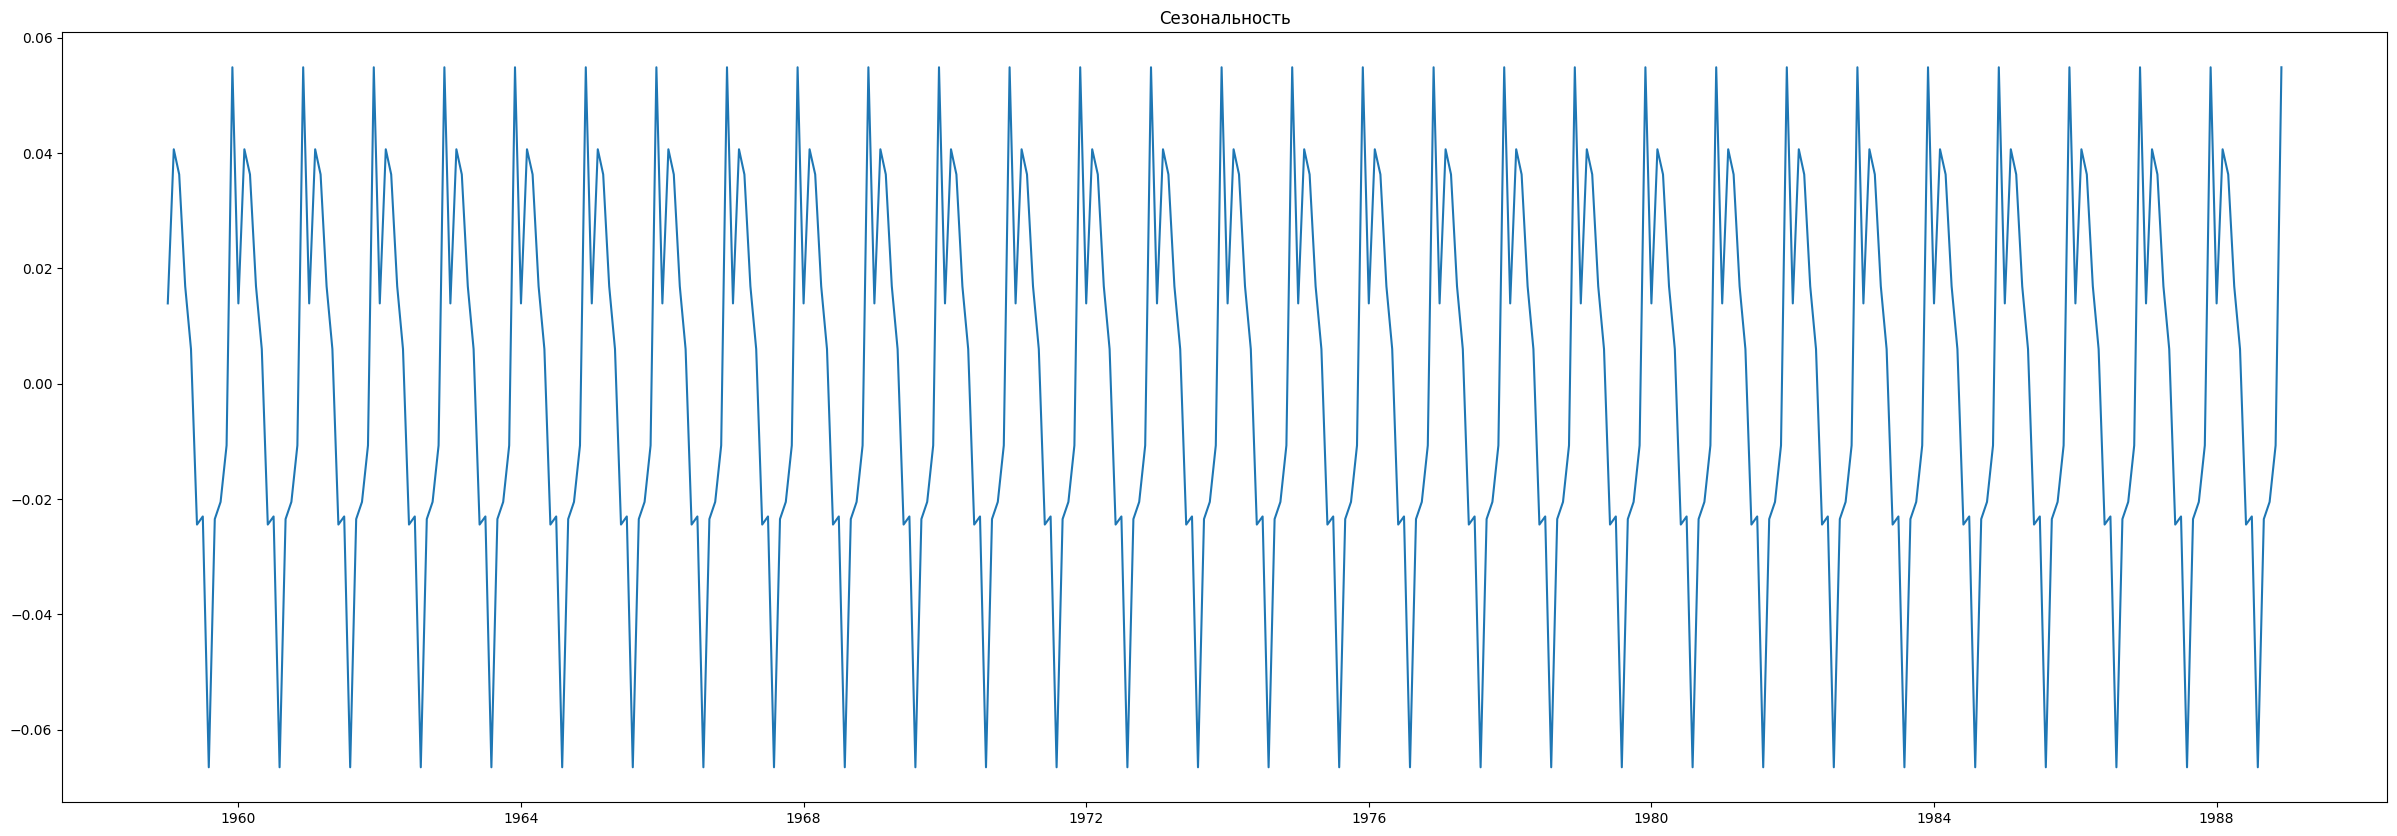

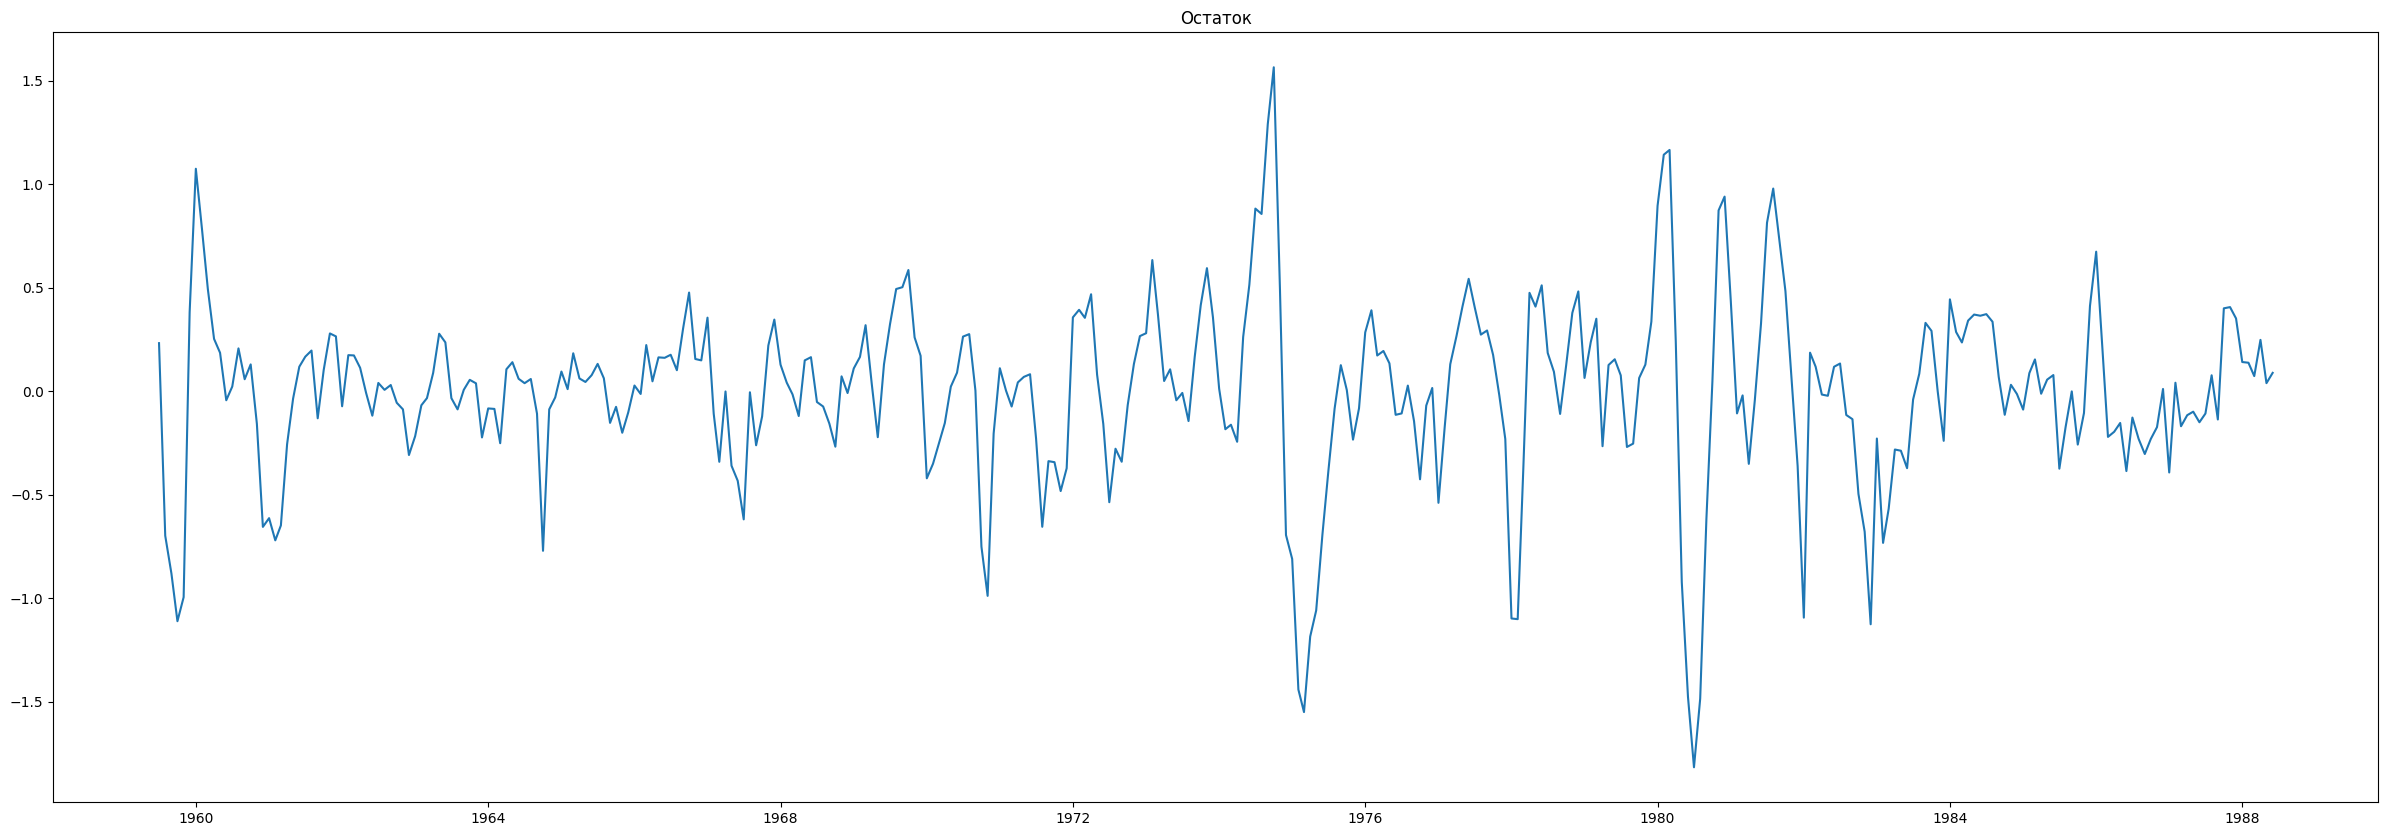

In [13]:
data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')


def show_plot(x, title=''):
    plt.figure(figsize=(30, 10))
    plt.plot(x)
    plt.title(title)
    plt.show()

trend = seasonal_decompose(data.Value).trend
resid = seasonal_decompose(data.Value).resid
seasonal = seasonal_decompose(data.Value).seasonal

show_plot(trend, 'Тренд')
show_plot(seasonal, 'Сезональность')
show_plot(resid, 'Остаток')

**Оценка стационарности тренда**

adf:  -0.8615760333584023
p-value:  0.8003625761532233
Critical values:  {'1%': -3.4503224123605194, '5%': -2.870338478726661, '10%': -2.571457612488522}
Не стационарно


False

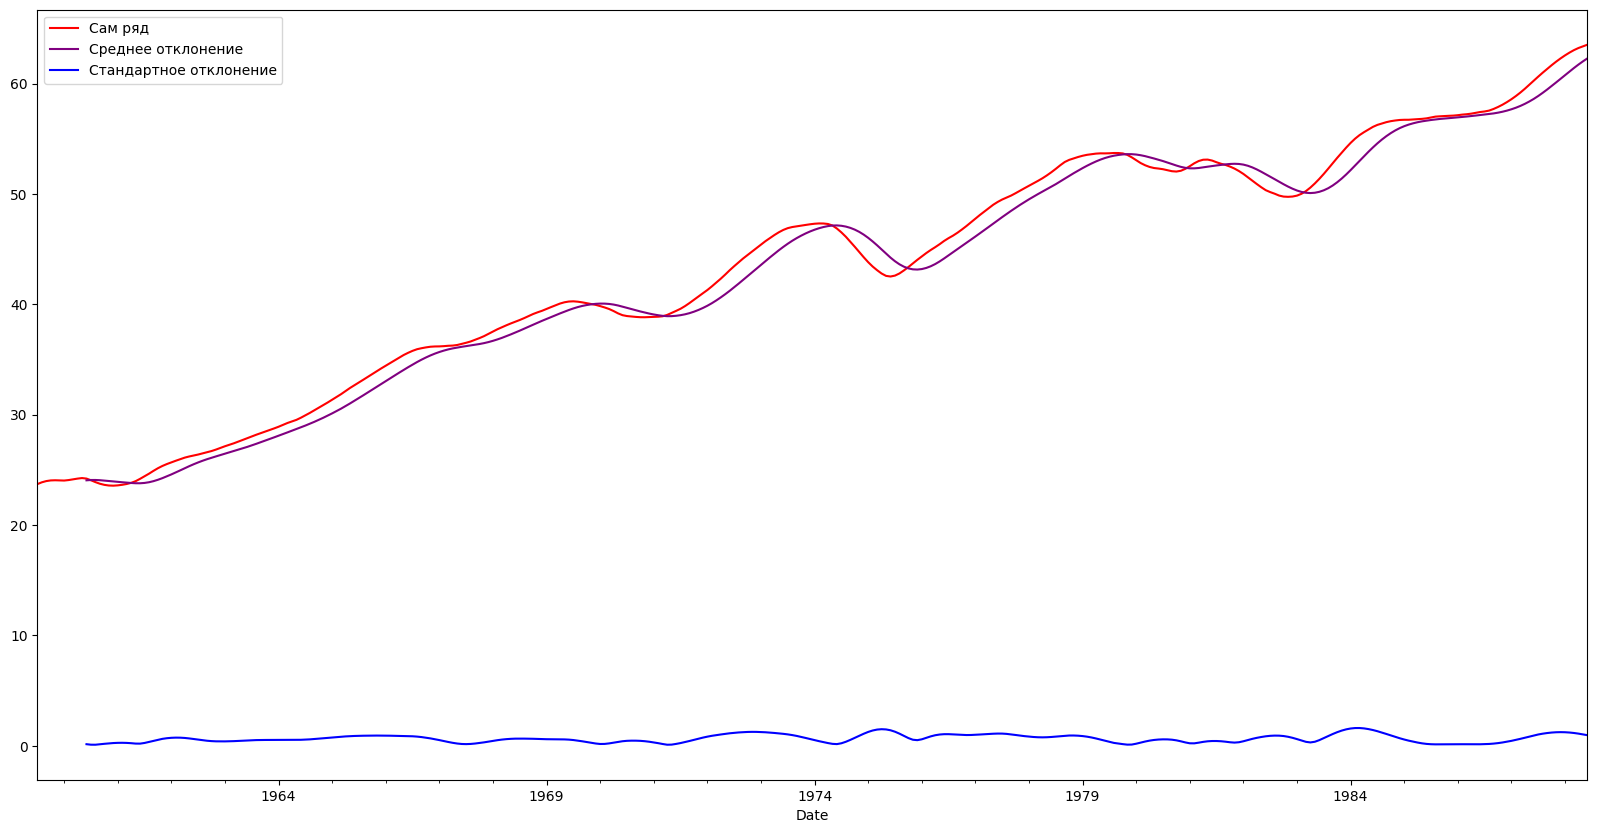

In [14]:
trend.dropna(inplace=True)
draw_stats(trend)
DF_test(trend)

**Оценка стационарности сезональности**

adf:  -540389567101099.7
p-value:  0.0
Critical values:  {'1%': -3.4492815848836296, '5%': -2.8698813715275406, '10%': -2.5712138845950587}
Стационарно


True

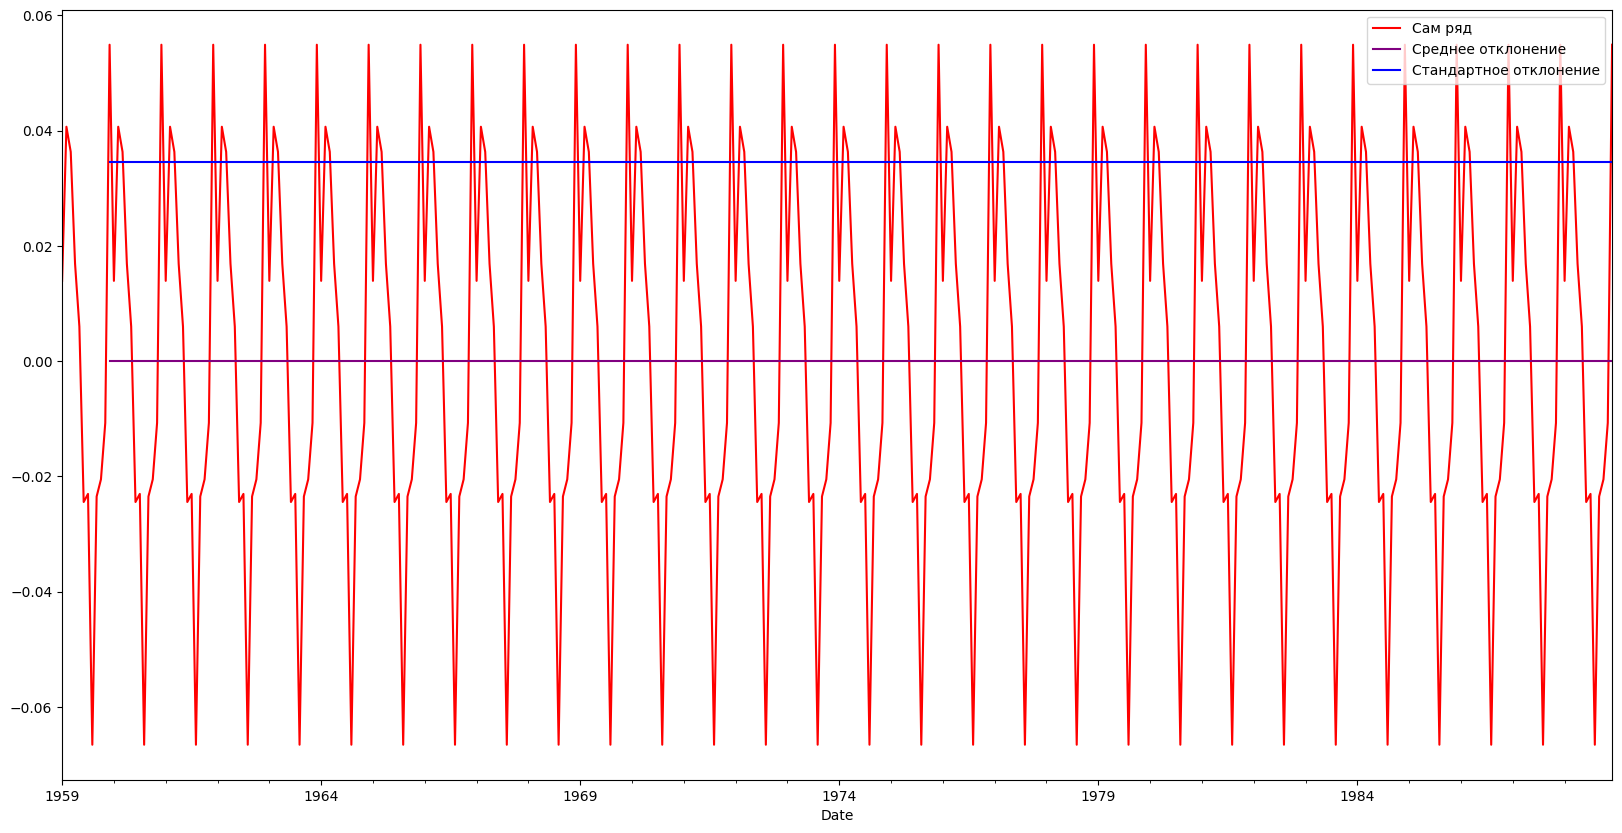

In [15]:
draw_stats(seasonal)
DF_test(seasonal)

**Оценка стационарности остатка**

adf:  -7.485563833765426
p-value:  4.649096674694056e-11
Critical values:  {'1%': -3.4496162602188187, '5%': -2.870028369720798, '10%': -2.5712922615505627}
Стационарно


True

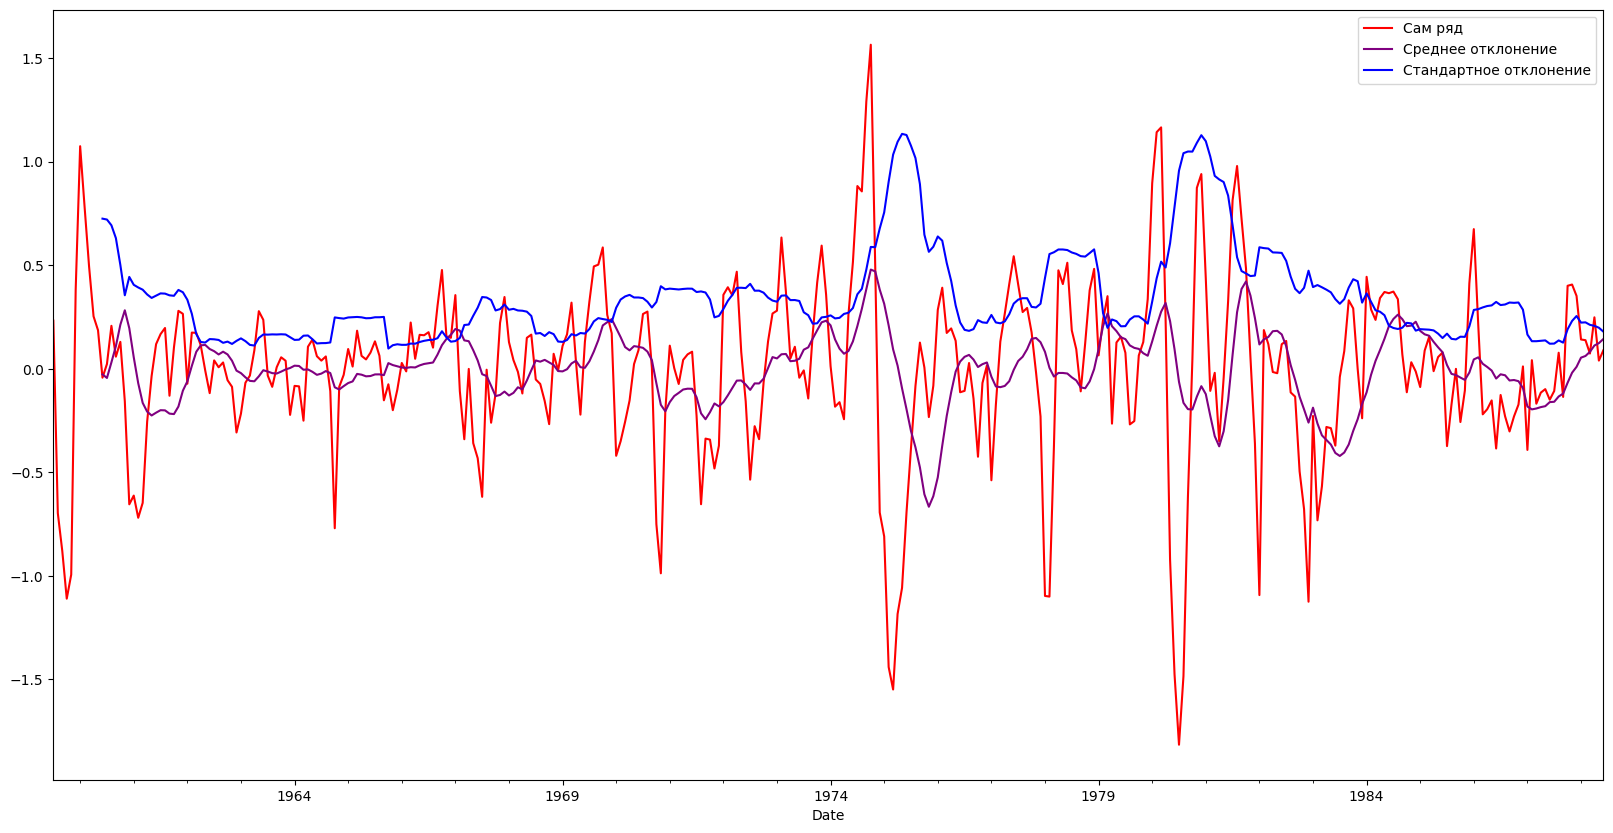

In [16]:
resid.dropna(inplace=True) #убирает nan
draw_stats(resid)
DF_test(resid)

**4. Проверка интегрируемости ряда.**

In [17]:
def find_order(train_ser, isPrint=False):
    integration_order = 0

    while not DF_test(train_ser, isPrint):
        train_ser = train_ser.diff(periods=1).dropna()
        integration_order += 1

    return integration_order

print("Порядок интегрируемости ряда:", find_order(train_ser))

Порядок интегрируемости ряда: 1


**Нахождение параметров автокорреляции**

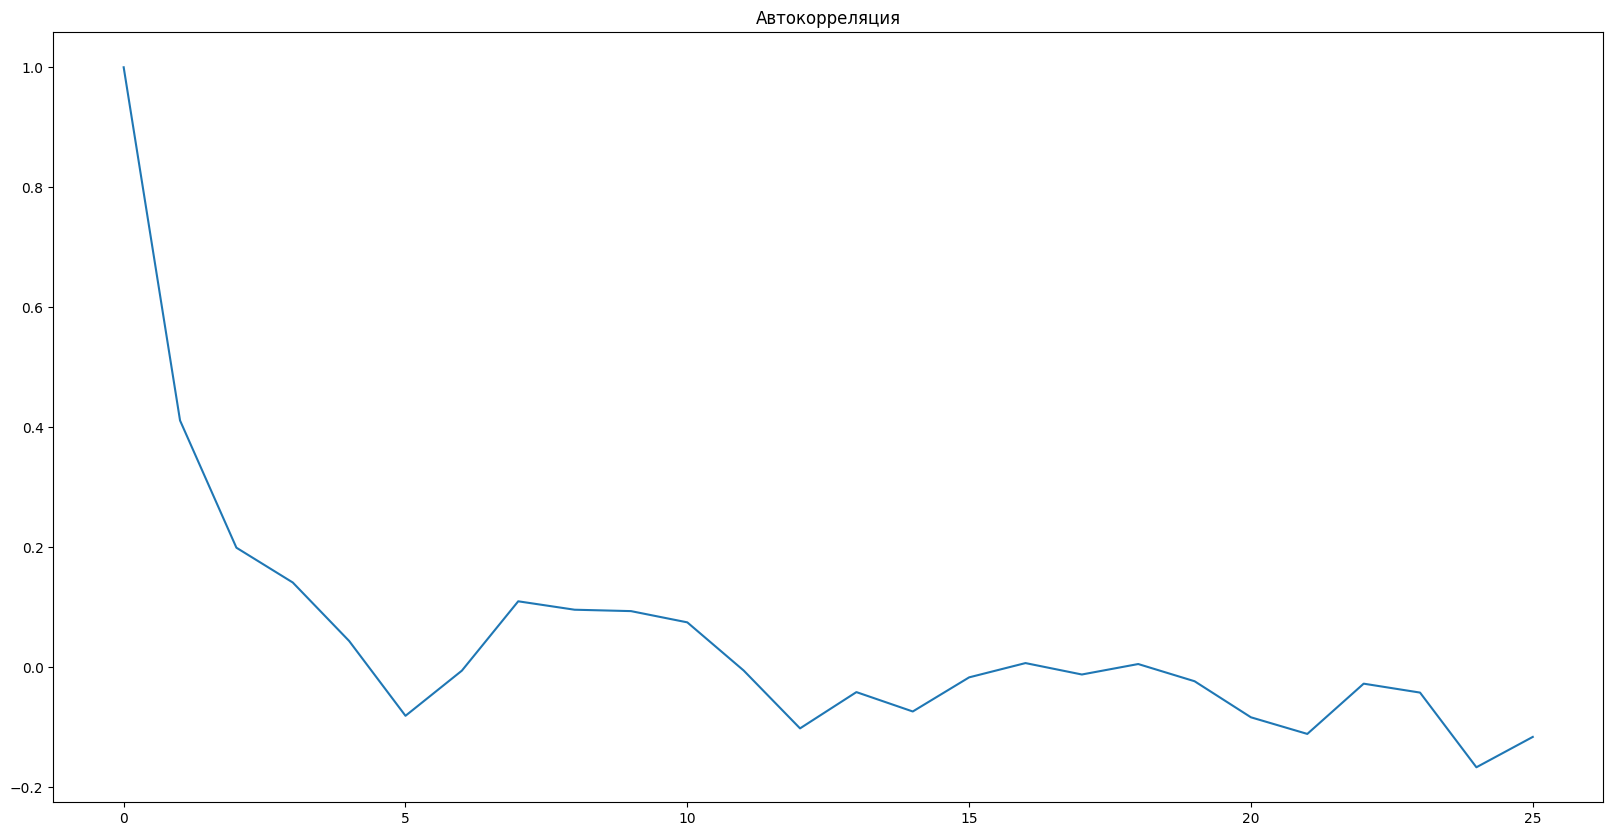

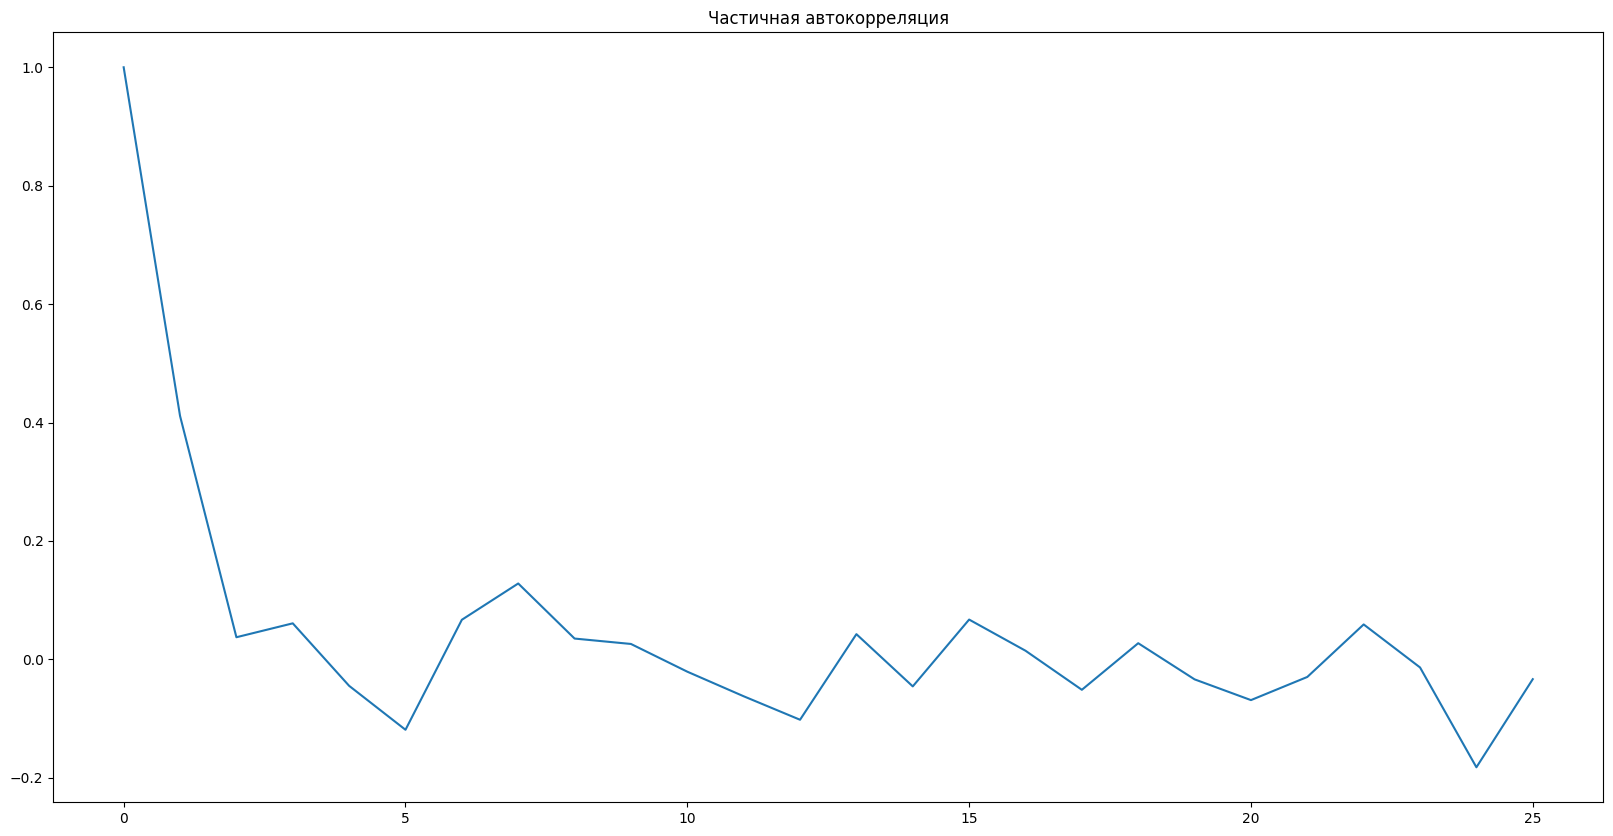

In [18]:
log_shift_train_ser = (np.log(train_ser) - np.log(train_ser).shift())
log_shift_train_ser.dropna(inplace=True)

acf = acf(log_shift_train_ser)
pacf = pacf(log_shift_train_ser, method='ols')

plt.figure(figsize=(20, 10))
plt.plot(acf)
plt.title('Автокорреляция')
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(pacf)
plt.title('Частичная автокорреляция')
plt.show()

**ARIMA  модель**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


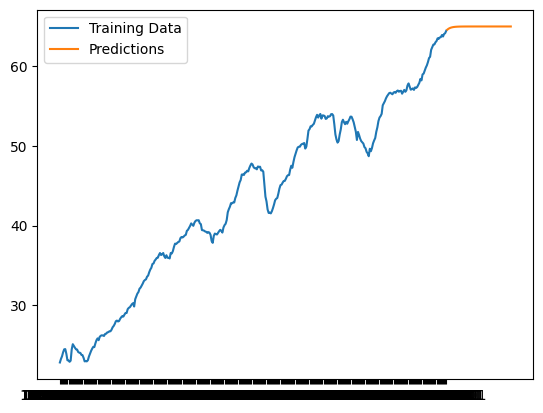

In [26]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

model = ARIMA(train_ser, order=(int(pacf[0]), 1, int(acf[0])))
fit_model = model.fit()

test_data = pd.read_csv('testing.csv')
predictions = fit_model.predict(start=len(train_ser), end=len(train_ser) + len(test_data) - 1, typ='levels')

# Визуализация предсказаний
plt.plot(train_ser, label='Training Data')
plt.plot(range(len(train_ser), len(train_ser) + len(test_data)), predictions, label='Predictions')
plt.legend()
plt.show()

In [30]:
from sklearn.metrics import r2_score

r2 = r2_score(test_data['Value'], predictions)
print('R-squared Score:', abs(r2))

R-squared Score: 0.02445374937970013


**Отбор нескольких моделей и использование информационного критерия Акаике (AIC)**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


AIC for (1, 1, 1): 255.6413548824527


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


AIC for (1, 0, 1): 299.8400763303025


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


AIC for (2, 1, 1): 256.85458483863914


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


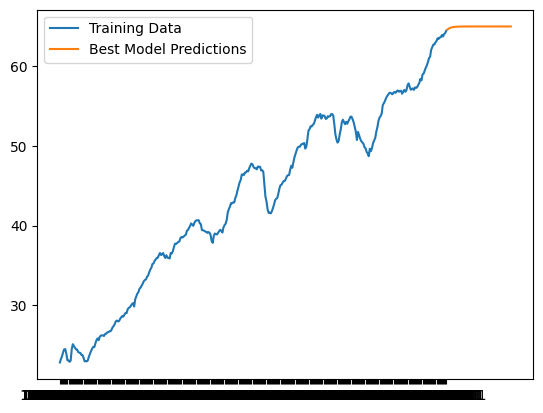

In [31]:
# Сравнение моделей на основе AIC
models = [(1, 1, 1), (1, 0, 1), (2, 1, 1)]  # Пример нескольких комбинаций параметров
best_aic = float('inf')
best_model = None

for params in models:
    model = ARIMA(train_ser, order=params)
    fit_model = model.fit()
    aic = fit_model.aic
    print(f'AIC for {params}: {aic}')

    if aic < best_aic:
        best_aic = aic
        best_model = fit_model

# Визуализация предсказаний лучшей модели
best_predictions = best_model.predict(start=len(train_ser), end=len(train_ser) + len(test_data) - 1, typ='levels')
plt.plot(train_ser, label='Training Data')
plt.plot(range(len(train_ser), len(train_ser) + len(test_data)), best_predictions, label='Best Model Predictions')
plt.legend()
plt.show()


**Тестовая выборка**

****

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


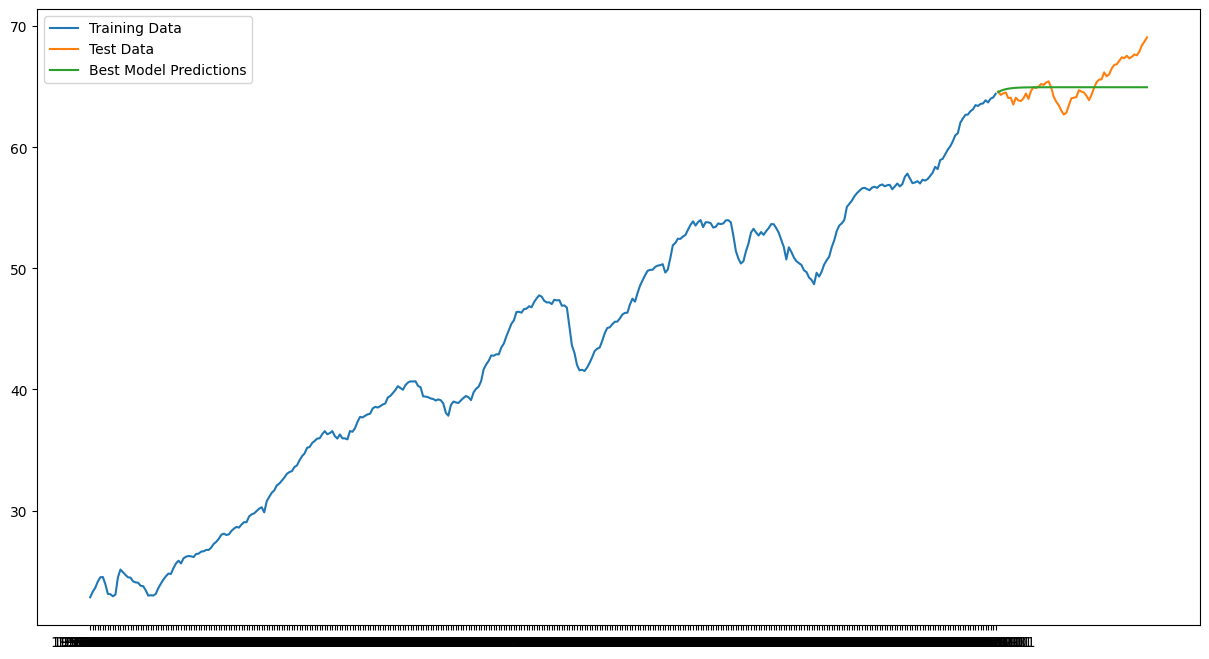

In [42]:
best_predictions = best_model.predict(start=len(train_ser), end=len(train_ser) + len(test_data) - 1, typ='levels')
plt.plot(train_ser, label='Training Data')
plt.plot(range(len(train_ser), len(train_ser) + len(test_data)), test_data['Value'], label='Test Data')
plt.plot(range(len(train_ser), len(train_ser) + len(test_data)), best_predictions, label='Best Model Predictions')
plt.legend()
plt.show()